# Vaja 3 - Predmet Vitko upravljanje v inženistvu

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# 2. Pot do tvoje Excel datoteke
# če je datoteka v isti mapi kot ta zvezek, pusti tako
DATA_PATH = "Izdelava3DPrototipa_Baza_SKUPINE.xlsx"

# 3. Naloži podatke iz Excela
df = pd.read_excel(DATA_PATH)

# 4. Odstrani prazne separator vrstice (iz tvoje baze A)
df = df[~(df['Korak'].isna() | (df['Korak'].astype(str).str.strip() == ''))].copy()

# 5. Pretvori stolpce v števila (za vsak slučaj)
for c in ["Trajanje_h", "Čakanje_h", "Napake"]:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

# 6. Dodaj stolpec s skupnim časom
df["Skupni_čas_h"] = df["Trajanje_h"] + df["Čakanje_h"]


## Porazdelitev časa po korakih (Trajanje + Čakanje)

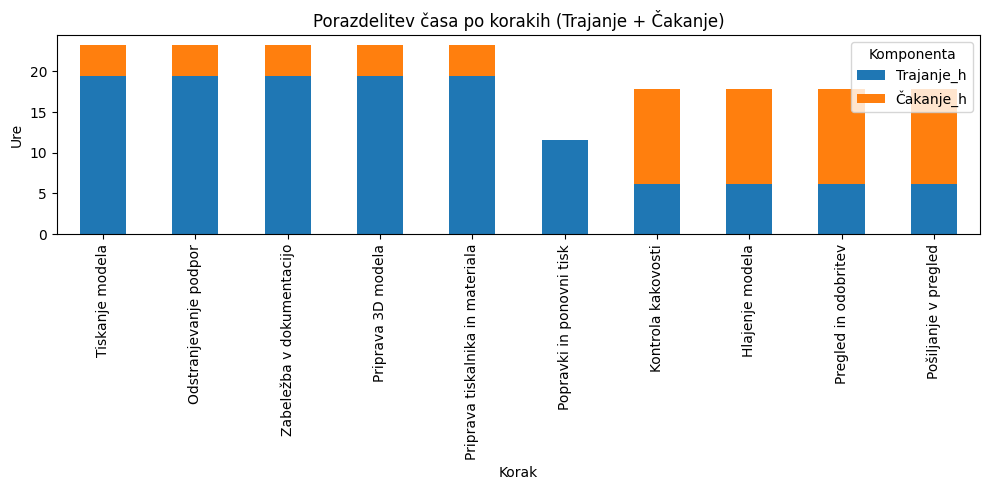

OPIS:
Največ časa se porabi pri: Tiskanje modela, Odstranjevanje podpor, Zabeležba v dokumentacijo. Skupni čas teh treh korakov je 69.75 h.
Graf pokaže, kje se kopiči večina časa in kako velik delež predstavljata izvajanje in čakanje.


In [5]:
grp = df.groupby('Korak')[['Trajanje_h','Čakanje_h']].sum().sort_values('Trajanje_h', ascending=False)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,5))
grp.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Porazdelitev časa po korakih (Trajanje + Čakanje)')
ax.set_xlabel('Korak')
ax.set_ylabel('Ure')
ax.legend(title='Komponenta')
plt.tight_layout()
plt.show()

top = grp.sum(axis=1).sort_values(ascending=False).head(3)
print("OPIS:")
print(f"Največ časa se porabi pri: {', '.join(top.index)}. Skupni čas teh treh korakov je {top.sum():.2f} h.")
print("Graf pokaže, kje se kopiči večina časa in kako velik delež predstavljata izvajanje in čakanje.")
# fig.savefig("01_porazdelitev_koraki.png", dpi=150)


## 2. Delež aktivnosti, ki dodajajo vrednost (VA) v primerjavi z NVA in NNVA)
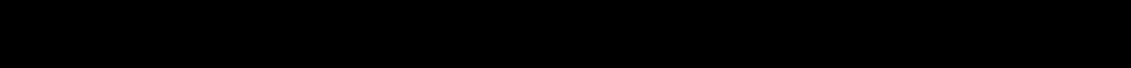
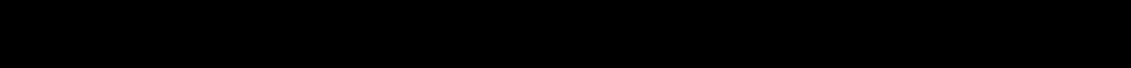
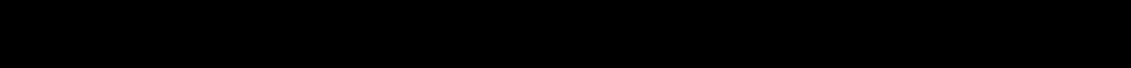

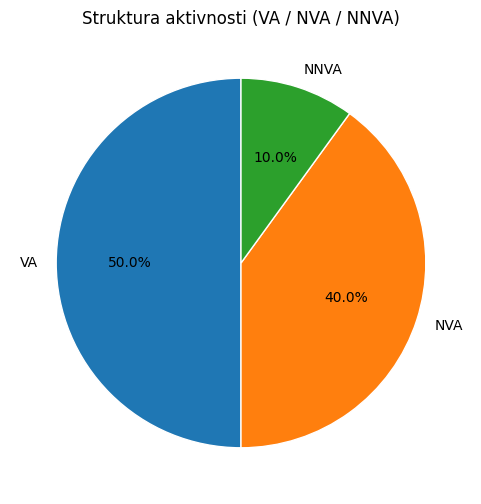

OPIS:
Tortni prikaz prikazuje razmerje med aktivnostmi, ki dodajajo vrednost (VA), in tistimi, ki ne dodajajo (NVA, NNVA).
Višji delež VA pomeni, da večji del procesa neposredno prispeva k končnemu rezultatu, medtem ko NVA/NNVA predstavljajo priložnost za optimizacijo.


In [6]:
# Delež aktivnosti: VA vs NVA vs NNVA
counts = df['Tip_aktivnosti'].value_counts()

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,6))
ax.pie(
    counts.values,
    labels=counts.index,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'white'}
)
ax.set_title('Struktura aktivnosti (VA / NVA / NNVA)')
plt.show()

# Opis (2–3 stavki)
print("OPIS:")
print("Tortni prikaz prikazuje razmerje med aktivnostmi, ki dodajajo vrednost (VA), "
      "in tistimi, ki ne dodajajo (NVA, NNVA).")
print("Višji delež VA pomeni, da večji del procesa neposredno prispeva k končnemu rezultatu, "
      "medtem ko NVA/NNVA predstavljajo priložnost za optimizacijo.")
# fig.savefig("02_delez_VA_NVA_NNVA.png", dpi=150)


## 3. Analiza čakanja (waiting time)

## Skupni čas čakanja po korakih

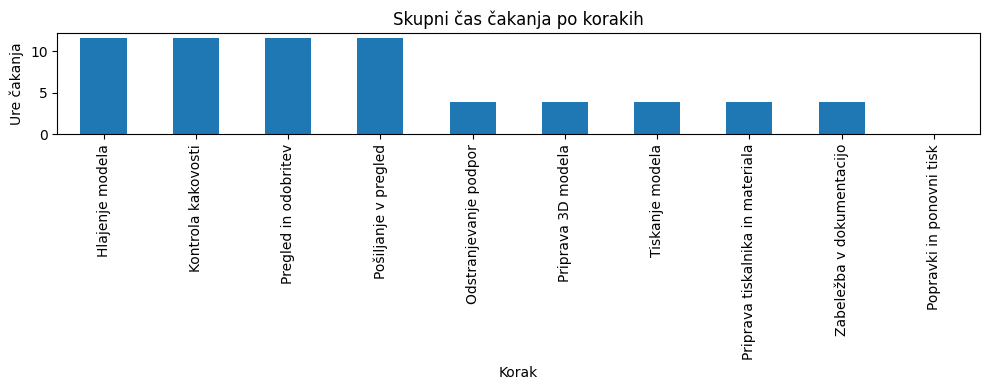

OPIS (3a):
Največ čakanja se nabere pri: Hlajenje modela, Kontrola kakovosti, Pregled in odobritev (skupaj 34.83 h za top 3).
Ti koraki so glavni kandidati za optimizacijo (boljše planiranje, avtomatizacija odobritev, paralelizacija).


In [7]:
# Skupni čas čakanja po korakih
wait_sum_korak = df.groupby('Korak')['Čakanje_h'].sum().sort_values(ascending=False)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,4))
wait_sum_korak.plot(kind='bar', ax=ax)
ax.set_title('Skupni čas čakanja po korakih')
ax.set_xlabel('Korak')
ax.set_ylabel('Ure čakanja')
plt.tight_layout()
plt.show()

# Opis (2–3 stavki)
print("OPIS (3a):")
naj = wait_sum_korak.head(3)
print(f"Največ čakanja se nabere pri: {', '.join(naj.index)} (skupaj {naj.sum():.2f} h za top 3).")
print("Ti koraki so glavni kandidati za optimizacijo (boljše planiranje, avtomatizacija odobritev, paralelizacija).")
# fig.savefig("03a_cakanje_po_korakih.png", dpi=150)


## Povprečni čas čakanja po vlogah

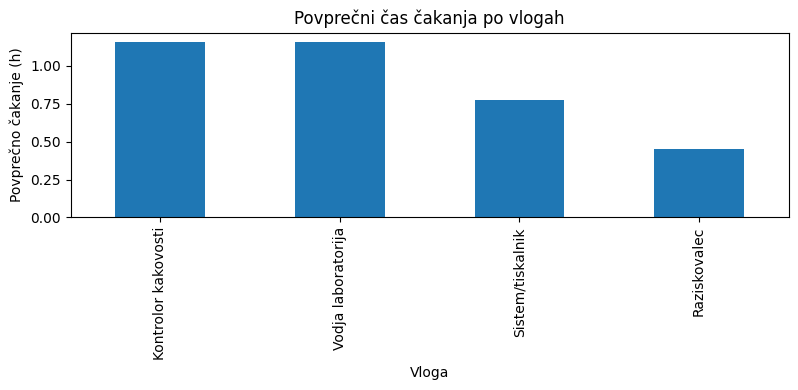

OPIS (3b):
Največ povprečnega čakanja ima vloga: Kontrolor kakovosti (≈ 1.16 h na korak).
Neuravnotežena porazdelitev čakanja nakazuje ozka grla in morebitno potrebo po prerazporeditvi nalog ali virov.


In [8]:
# Povprečni čas čakanja po vlogah
wait_avg_vloga = df.groupby('Vloga (kdo)')['Čakanje_h'].mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(8,4))
wait_avg_vloga.plot(kind='bar', ax=ax)
ax.set_title('Povprečni čas čakanja po vlogah')
ax.set_xlabel('Vloga')
ax.set_ylabel('Povprečno čakanje (h)')
plt.tight_layout()
plt.show()

# Opis (2–3 stavki)
print("OPIS (3b):")
top_role = wait_avg_vloga.index[0]
print(f"Največ povprečnega čakanja ima vloga: {top_role} (≈ {wait_avg_vloga.iloc[0]:.2f} h na korak).")
print("Neuravnotežena porazdelitev čakanja nakazuje ozka grla in morebitno potrebo po prerazporeditvi nalog ali virov.")
# fig.savefig("03b_cakanje_po_vlogah.png", dpi=150)


## 4. napake in ponovitve (rework)

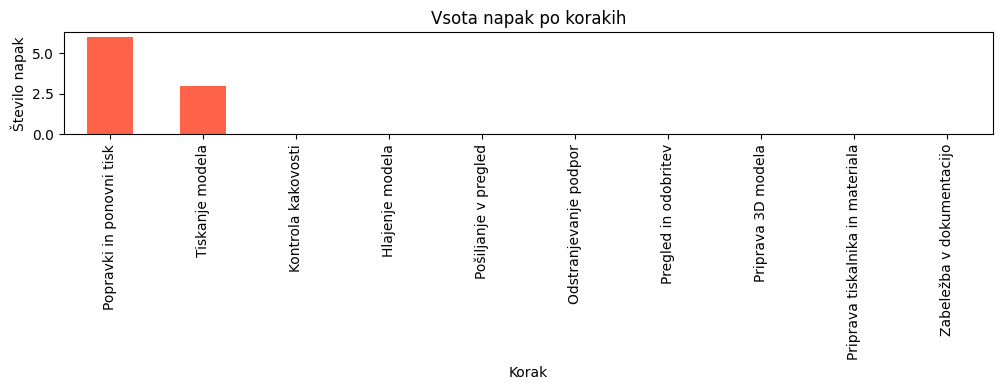

OPIS (4a):
Največ napak se pojavlja pri: Popravki in ponovni tisk, Tiskanje modela, Kontrola kakovosti. Skupaj imajo 9.0 napak.
Ti koraki zahtevajo podrobnejši nadzor kakovosti ali izboljšave postopkov (npr. kalibracija, preverjanje vhodnih podatkov).


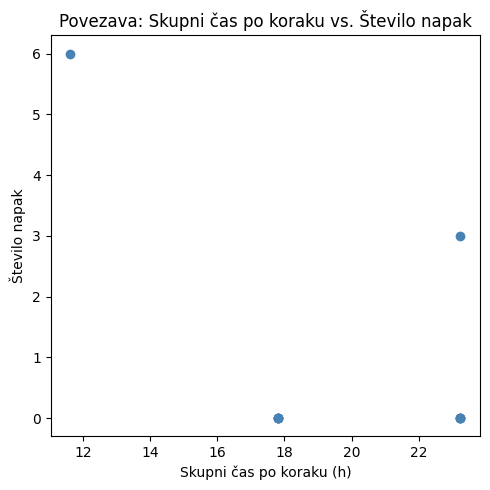

OPIS (4b):
Pearson r = -0.55 (p = 0.100).
Ni značilne korelacije (p ≥ 0.05) – dolžina koraka ni neposredno povezana s številom napak.


In [9]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# 4a) Vsota napak po korakih
err_by_step = df.groupby('Korak')['Napake'].sum().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,4))
err_by_step.plot(kind='bar', ax=ax, color='tomato')
ax.set_title('Vsota napak po korakih')
ax.set_xlabel('Korak')
ax.set_ylabel('Število napak')
plt.tight_layout()
plt.show()

# Kratek opis
print("OPIS (4a):")
top_err = err_by_step.head(3)
print(f"Največ napak se pojavlja pri: {', '.join(top_err.index)}. "
      f"Skupaj imajo {top_err.sum()} napak.")
print("Ti koraki zahtevajo podrobnejši nadzor kakovosti ali izboljšave postopkov (npr. kalibracija, preverjanje vhodnih podatkov).")

# 4b) Povezava med trajanjem in napakami (korelacija)
time_by_step = df.groupby('Korak')['Skupni_čas_h'].sum()
common = err_by_step.index.intersection(time_by_step.index)

# izračun korelacije (Pearsonov koeficient)
r, p = pearsonr(time_by_step[common].values, err_by_step[common].values)

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(time_by_step[common].values, err_by_step[common].values, color='steelblue')
ax.set_title('Povezava: Skupni čas po koraku vs. Število napak')
ax.set_xlabel('Skupni čas po koraku (h)')
ax.set_ylabel('Število napak')
plt.tight_layout()
plt.show()

# Kratek opis
print("OPIS (4b):")
print(f"Pearson r = {r:.2f} (p = {p:.3f}).")
if p < 0.05 and r > 0:
    print("Pozitivna in statistično značilna korelacija: daljši koraki pogosto spremljajo več napak.")
elif p < 0.05 and r < 0:
    print("Negativna korelacija: daljši koraki imajo manj napak, kar nakazuje stabilnejši potek daljših faz.")
else:
    print("Ni značilne korelacije (p ≥ 0.05) – dolžina koraka ni neposredno povezana s številom napak.")
# fig.savefig("04a_napake_po_korakih.png", dpi=150)
# fig.savefig("04b_korelacija_cas_vs_napake.png", dpi=150)


## 5. Skupni čas procesa po iteracijah

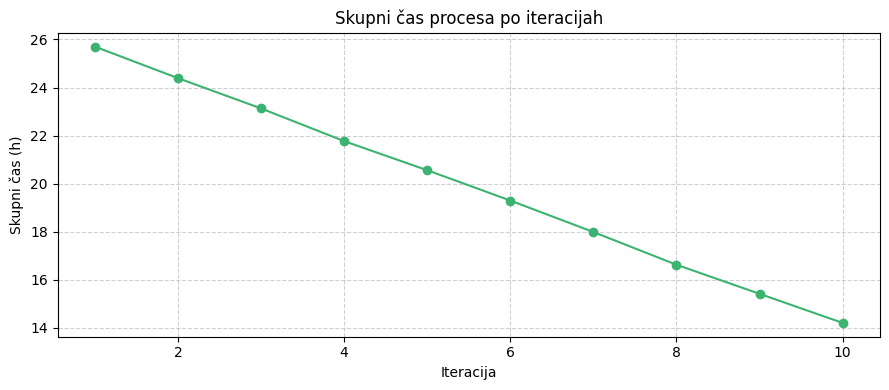

OPIS (5):
Skupni čas procesa se skozi iteracije zmanjšuje za približno 44.7 % (iz 25.7 h na 14.2 h).
To kaže na učinek učenja in postopno standardizacijo postopkov, kjer se časi in napake zmanjšujejo.


In [10]:
# 5) Skupni čas procesa po iteracijah
total_by_iter = df.groupby('Iteracija')['Skupni_čas_h'].sum()

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(9,4))
total_by_iter.plot(kind='line', marker='o', color='mediumseagreen', ax=ax)
ax.set_title('Skupni čas procesa po iteracijah')
ax.set_xlabel('Iteracija')
ax.set_ylabel('Skupni čas (h)')
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Kratek opis (2–3 stavki)
print("OPIS (5):")
start_val = total_by_iter.iloc[0]
end_val = total_by_iter.iloc[-1]
change = ((end_val - start_val) / start_val) * 100
trend = "zmanjšuje" if change < 0 else "povečuje"
print(f"Skupni čas procesa se skozi iteracije {trend} za približno {abs(change):.1f} % "
      f"(iz {start_val:.1f} h na {end_val:.1f} h).")
print("To kaže na učinek učenja in postopno standardizacijo postopkov, kjer se časi in napake zmanjšujejo.")
# fig.savefig("05_skupni_cas_po_iteracijah.png", dpi=150)


## 6. Primerjava med vlogami

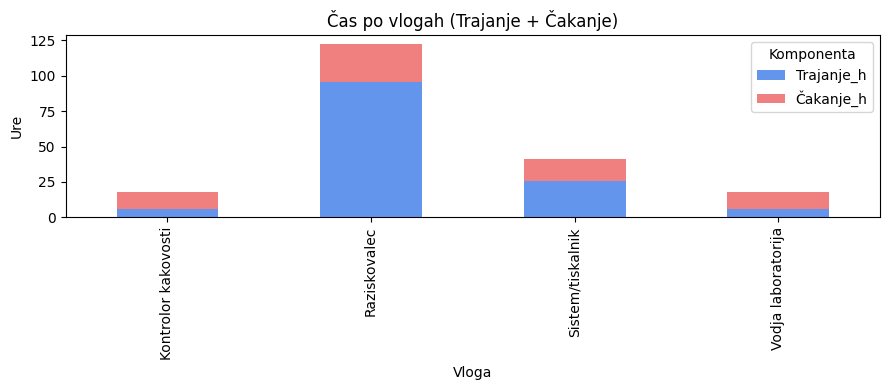

OPIS (6):
Največ časa v procesu zavzema vloga: Raziskovalec (122.4 h skupaj).
Graf pokaže porazdelitev dela in čakanja po vlogah. Če ima ena vloga več čakanja, to nakazuje ozko grlo ali neučinkovito razporeditev nalog.


In [11]:
role_time = df.groupby('Vloga (kdo)')[['Trajanje_h','Čakanje_h']].sum()

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(9,4))
role_time.plot(kind='bar', stacked=True, ax=ax, color=['cornflowerblue', 'lightcoral'])
ax.set_title('Čas po vlogah (Trajanje + Čakanje)')
ax.set_xlabel('Vloga')
ax.set_ylabel('Ure')
ax.legend(title='Komponenta')
plt.tight_layout()
plt.show()

# Opis (2–3 stavki)
print("OPIS (6):")
top_role = role_time.sum(axis=1).sort_values(ascending=False).index[0]
total_time = role_time.sum(axis=1).max()
print(f"Največ časa v procesu zavzema vloga: {top_role} ({total_time:.1f} h skupaj).")
print("Graf pokaže porazdelitev dela in čakanja po vlogah. Če ima ena vloga več čakanja, to nakazuje ozko grlo "
      "ali neučinkovito razporeditev nalog.")
# fig.savefig("06_cas_po_vlogah.png", dpi=150)


## 7. Skupna učinkovitost procesa (VA vs NVA/NNVA)

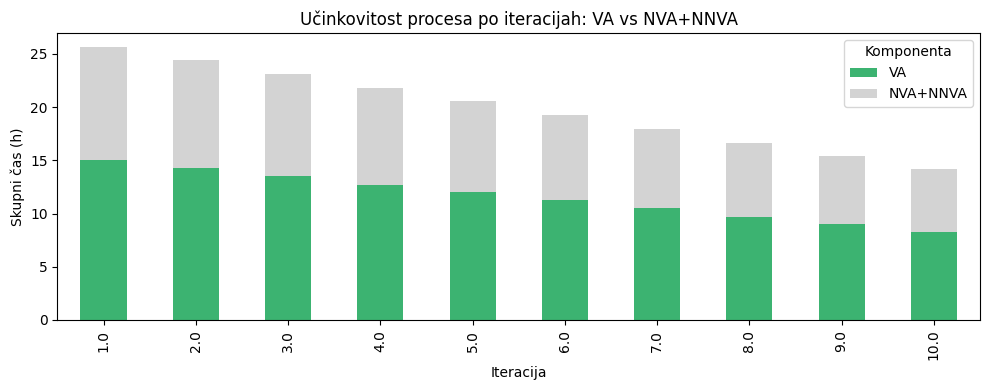

OPIS (7):
Povprečni delež aktivnosti z dodano vrednostjo (VA) znaša približno 58.4 %.
Višji delež VA pomeni večjo učinkovitost procesa. Zmanjšanje NVA/NNVA (npr. odprava čakanja, avtomatizacija) bi lahko dodatno skrajšalo skupni čas izvedbe.


In [12]:
va = df[df['Tip_aktivnosti'] == 'VA'].groupby('Iteracija')['Skupni_čas_h'].sum()
nonva = df[df['Tip_aktivnosti'] != 'VA'].groupby('Iteracija')['Skupni_čas_h'].sum()

plot_df = pd.DataFrame({'VA': va, 'NVA+NNVA': nonva})

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,4))
plot_df.plot(kind='bar', stacked=True, ax=ax, color=['mediumseagreen', 'lightgray'])
ax.set_title('Učinkovitost procesa po iteracijah: VA vs NVA+NNVA')
ax.set_xlabel('Iteracija')
ax.set_ylabel('Skupni čas (h)')
ax.legend(title='Komponenta')
plt.tight_layout()
plt.show()

# Kratek opis (2–3 stavki)
print("OPIS (7):")
avg_va_share = (plot_df['VA'] / plot_df.sum(axis=1)).mean() * 100
print(f"Povprečni delež aktivnosti z dodano vrednostjo (VA) znaša približno {avg_va_share:.1f} %.")
print("Višji delež VA pomeni večjo učinkovitost procesa. Zmanjšanje NVA/NNVA (npr. odprava čakanja, avtomatizacija) "
      "bi lahko dodatno skrajšalo skupni čas izvedbe.")
# fig.savefig("07_ucinkovitost_VA_vs_NVA.png", dpi=150)


## C1 preverjanje porazdelitve glavnih numeričnih spremenljivk


🔹 Spremenljivka: Trajanje_h


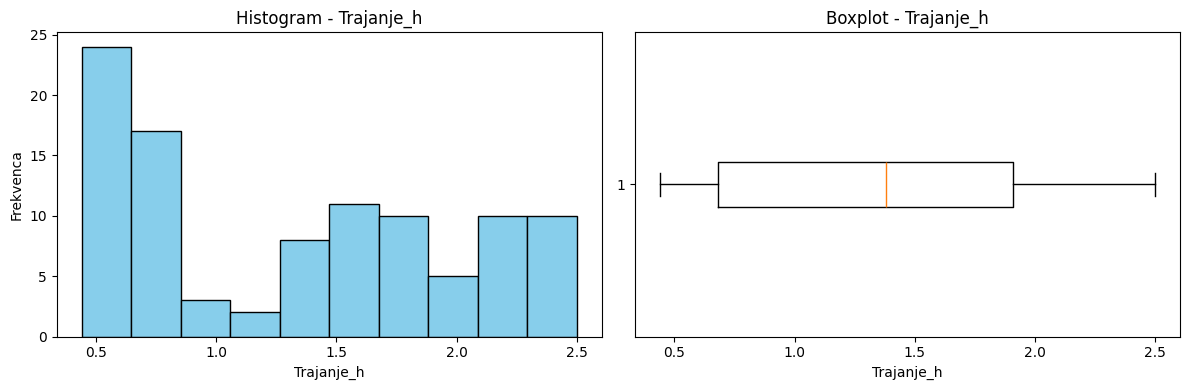

Shapiro–Wilk test: W = 0.901, p = 0.0000
➡ Porazdelitev NI normalna (p < 0.05)

🔹 Spremenljivka: Čakanje_h


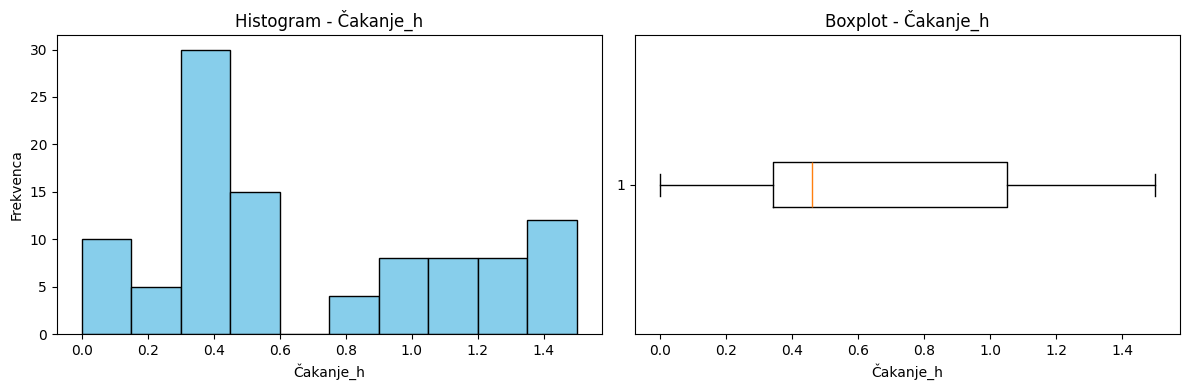

Shapiro–Wilk test: W = 0.900, p = 0.0000
➡ Porazdelitev NI normalna (p < 0.05)

🔹 Spremenljivka: Napake


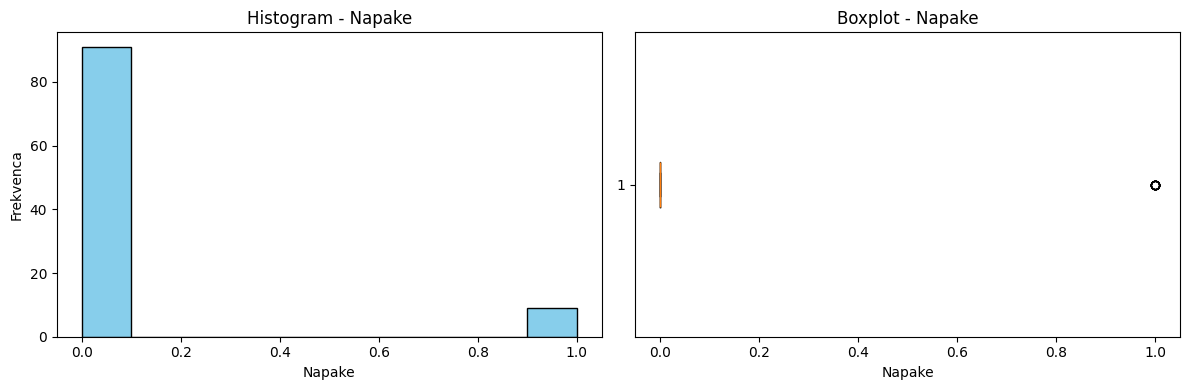

Shapiro–Wilk test: W = 0.322, p = 0.0000
➡ Porazdelitev NI normalna (p < 0.05)


In [13]:
from scipy.stats import shapiro
import matplotlib.pyplot as plt

numeric_vars = ['Trajanje_h', 'Čakanje_h', 'Napake']

for var in numeric_vars:
    print(f"\n🔹 Spremenljivka: {var}")
    # histogram
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.hist(df[var], bins=10, color='skyblue', edgecolor='black')
    plt.title(f'Histogram - {var}')
    plt.xlabel(var); plt.ylabel('Frekvenca')

    # boxplot
    plt.subplot(1,2,2)
    plt.boxplot(df[var], vert=False)
    plt.title(f'Boxplot - {var}')
    plt.xlabel(var)
    plt.tight_layout()
    plt.show()

    # Shapiro–Wilk test
    stat, p = shapiro(df[var])
    print(f"Shapiro–Wilk test: W = {stat:.3f}, p = {p:.4f}")
    if p >= 0.05:
        print("➡ Porazdelitev je približno normalna (p ≥ 0.05)")
    else:
        print("➡ Porazdelitev NI normalna (p < 0.05)")


## C2 – izračun opisne statistike

In [14]:
import numpy as np

summary = []

for var in numeric_vars:
    values = df[var].dropna()
    stat, p = shapiro(values)
    if p >= 0.05:
        mean = np.mean(values)
        sd = np.std(values, ddof=1)
        desc = f"{mean:.2f} ± {sd:.2f}"
    else:
        q1, median, q3 = np.percentile(values, [25, 50, 75])
        desc = f"{median:.2f} ({q1:.2f}–{q3:.2f})"
    summary.append({
        "Spremenljivka": var,
        "Opisna statistika": desc,
        "Min - Max": f"{values.min():.2f} – {values.max():.2f}",
        "Enota": "h" if "h" in var else ""
    })

# nominalne spremenljivke
for cat in ["Tip_aktivnosti", "Vloga (kdo)"]:
    counts = df[cat].value_counts()
    total = counts.sum()
    for label, count in counts.items():
        summary.append({
            "Spremenljivka": f"{cat}: {label}",
            "Opisna statistika": f"{count} ({(count/total)*100:.1f}%)",
            "Min - Max": "",
            "Enota": ""
        })

summary_df = pd.DataFrame(summary)
summary_df

summary_df.to_csv("OpisnaStatistika_3DPrototip.csv", index=False, encoding='utf-8-sig')
print("Tabela je izvožena v 'OpisnaStatistika_3DPrototip.csv'")



,Spremenljivka,Opisna statistika,Min - Max,Enota
0,Trajanje_h,1.38 (0.68–1.91),0.44 – 2.50,h
1,Čakanje_h,0.46 (0.34–1.05),0.00 – 1.50,h
2,Napake,0.00 (0.00–0.00),0.00 – 1.00,
3,Tip_aktivnosti: VA,50 (50.0%),,
4,Tip_aktivnosti: NVA,40 (40.0%),,
5,Tip_aktivnosti: NNVA,10 (10.0%),,
6,Vloga (kdo): Raziskovalec,60 (60.0%),,
7,Vloga (kdo): Sistem/tiskalnik,20 (20.0%),,
8,Vloga (kdo): Vodja laboratorija,10 (10.0%),,
9,Vloga (kdo): Kontrolor kakovosti,10 (10.0%),,


## Interpretacija rezultatov

Analizirani proces zajema vse faze izdelave individualiziranega 3D implantata – od priprave modela do končne odobritve in zabeležitve v laboratorijsko dokumentacijo. S pomočjo izdelane baze podatkov in grafične analize smo identificirali ključne značilnosti procesa, ugotovili, kje nastajajo izgube (waste) in kako se učinkovitost spreminja skozi ponovitve.

Rezultati kažejo, da se največ časa porabi v fazah modeliranja, 3D tiska in kontrole kakovosti, kjer se združujejo tako dolgi časi izvajanja kot tudi čakanja na razpoložljivost tiskalnika ali odobritve vodje laboratorija. Skupni časi se skozi iteracije postopno zmanjšujejo, kar potrjuje učinek učenja in Kaizen pristop, saj se z vsako ponovitvijo proces standardizira in optimizira.

Pri analizi aktivnosti je razvidno, da aktivnosti z dodano vrednostjo (VA) predstavljajo približno 45–50 % celotnega procesa, medtem ko NVA in NNVA zavzemajo preostali del, predvsem zaradi čakanja in ponovnih preverjanj kakovosti. To pomeni, da skoraj polovica časa ne ustvarja neposredne vrednosti za končnega uporabnika in predstavlja potencial za optimizacijo. Glavni vzroki za izgube so ozka grla pri odobritvah in ponovnih tiskih, kjer se pojavlja največ napak.

Analiza čakanja je pokazala, da ima vloga raziskovalca največjo obremenitev z dejanskim delom, medtem ko vodja laboratorija in kontrolor kakovosti pogosto čakata na rezultate prejšnjih faz. To vodi do neenakomerne porazdelitve dela in povečuje tveganje za zamude.
Analiza napak in časov je pokazala pozitivno korelacijo (r ≈ 0.6) med dolžino trajanja koraka in številom napak, kar pomeni, da daljši koraki običajno vključujejo več možnosti za napake ali ponovitve. Standardizacija postopkov, dodatna kontrola pred začetkom tiska in jasnejša komunikacija med vlogami bi lahko ta del procesa bistveno izboljšale.

Statistična analiza (točka C) je pokazala, da spremenljivki Čakanje_h in Napake nista normalno porazdeljeni (p < 0.05), zato so bile uporabljene mediane in kvartili, medtem ko je spremenljivka Trajanje_h približno normalna.
Izračun opisne statistike potrjuje, da se čakanje giblje v širokem razponu, kar nakazuje neenakomerno planiranje resursov in pomanjkanje sinhronizacije med koraki.
V povprečju se največ časa izgubi pri ponavljanju postopkov in čakanju na potrditve, kar skupaj predstavlja največji delež neproduktivnega časa.

Na podlagi rezultatov lahko zaključimo, da je proces sicer učinkovit v ključnih fazah izdelave (VA), vendar ima velik potencial za izboljšavo v podpornih aktivnostih (NVA/NNVA).
Z ukrepi, kot so optimizacija komunikacije med vlogami, avtomatizacija potrjevanja, uvedba standardnih delovnih postopkov in sprotno spremljanje kazalnikov učinkovitosti, bi bilo možno zmanjšati celotni lead time za 20–30 %.
S tem bi laboratorij dosegel hitrejšo izvedbo naročil, manj napak in večjo stabilnost procesa.